1 L.ibrary Imports

This cell installs all the necessary additional libraries.

In [15]:
!pip install scikit-learn -q
!pip install wbdata -q

This cell imports all the necessary libraries.

In [16]:
import logging
import warnings
# Suppresses warning errors, there are too many of them there about caches from wbdata
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
import wbdata
import pandas as pd
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from data_handler import Data_Handler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# 2. Datasets
## 2.1 Pulling the data
Add a description of which indicators we chose for each data set and why

In [17]:
# Initialise data indicators and relative names for the columns in the data
indicators_gidd = {
    "new_displacement": "New displacement",
    "hazard_type_name": "Hazard type"
}

indicators_hdi = {
    "gnipc": "Gross National Income Per Capita",
    "ineq_inc": "Income Inequality",
    "le": "Life Expectancy at Birth",
    "gii": "Gender Inequality Index",
}

indicators_wb = {
    "EN.POP.DNST": "population_density",
    "SP.DYN.IMRT.IN": "infant_mortality_rate",
    "SL.EMP.TOTL.SP.ZS": "employment_rate",
}
# Get GIDD data
gidd_data = Data_Handler.get_data_GIDD(
    client_id="92DWGXNPOLOM7DR6",
    indicators = indicators_gidd,
    iso3=None,
    start_year=2013,
    end_year=2023,
)
# Get HDI data
hdi_data = Data_Handler.get_data_HDI(
    filepath="HDR25_Composite_indices_complete_time_series.csv",
    indicators=indicators_hdi,
    countries=None,
    start_year=2013,
    end_year=2023
)
# Get WB data
wbdata = Data_Handler.get_data_WB(
    indicators = indicators_wb, 
    countries="all", 
    start_year=2013,
    end_year=2023
 )


do we want one column per  year and country or have it per event ??

In [18]:
# Pivot the HDI dataset so that each metric_name becomes a column
hdi_data_pivot = hdi_data.pivot_table(
    index=['iso3', 'year'],   
    columns='metric_name',       
    values='value'               
).reset_index()                  

# Rename columns for consistency
wbdata.rename(columns={'Year': 'year'}, inplace=True)
wbdata.rename(columns={'ISO3': 'iso3'}, inplace=True)

# Merge datasets on 'iso3' and 'year'
data = (gidd_data
        .merge(hdi_data_pivot, on=['iso3', 'year'], how='outer')
        .merge(wbdata, on=['iso3', 'year'], how='outer')
       )

In [19]:
hdi_iso3 = set(hdi_data_pivot['iso3'].unique())
gidd_iso3 = set(gidd_data['iso3'].unique())

print("ISO3 codes only in HDI:", hdi_iso3 - gidd_iso3)
print("ISO3 codes only in IDMC:", gidd_iso3 - hdi_iso3)

ISO3 codes only in HDI: {'ZZK.WORLD', 'LIE', 'MDA', 'BHR', 'SMR', 'MCO', 'ZZB.HHD', 'ARM', 'SGP', 'AND', 'EST', 'TKM', 'LTU', 'QAT', 'GNQ', 'ZZJ.SSA', 'ZZD.LHD', 'ZZI.SA', 'ZZC.MHD', 'MLT', 'ZZE.AS', 'ZZF.EAP', 'NRU', 'ZZH.LAC', 'ZZG.ECA', 'ZZA.VHHD'}
ISO3 codes only in IDMC: {'MNP', 'AIA', 'TWN', 'REU', 'GUM', 'AB9', 'PRI', 'VIR', 'GLP', 'SXM', 'IMN', 'GRL', 'MAC', 'XKX', 'CYM', 'COK', 'MAF', 'JEY', 'TCA', 'MYT', 'NCL', 'MTQ', 'BMU', 'PYF', 'GUF', 'ASM', 'VGB'}


In [20]:
# Find the intersection of ISO3 codes
hdi_iso3 = set(hdi_data_pivot['iso3'].dropna().unique())
gidd_iso3 = set(gidd_data['iso3'].dropna().unique())

common_iso3 = hdi_iso3 & gidd_iso3  # intersection

# Keep only rows in `data` with ISO3 codes in both datasets and not missing
data = data[data['iso3'].isin(common_iso3) & data['iso3'].notna()]


based on this do we get rid of countries??

## 2.2 Data preprocessing
In this section, we complete all necessary data preprocessing.

We plotted the missing values by year in a bar graph.

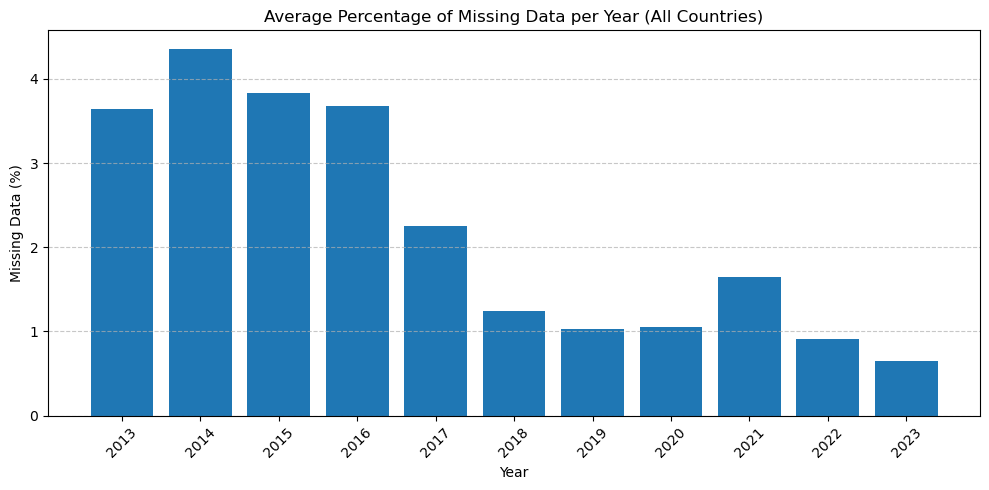

In [10]:
# Exclude trivial columns
cols_to_check = [c for c in data.columns if c not in ['year', 'iso3']]

# Percentage of NaN values per year (average across all countries and columns)
nan_by_year = data.groupby('year')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_by_year.index.astype(str), nan_by_year.values)
plt.title('Average Percentage of Missing Data per Year (All Countries)')
plt.xlabel('Year')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Although the dataset contains missing values, missingness is not uniform across time. Missing data are highest in the early period (2013–2016, approximately 35–45%), decrease substantially in 2017 (≈20%), and 2018 (≈10%). From there onwards it remains low around 10% except for 2021.

Excluding early years would therefore disproportionately remove information from the beginning of the analysis period and compress the time dimension. Because the missingness declines  over time and is driven primarily by data availability rather than  changes in the underlying phenomena, retaining all years allows temporal continuity.

Next, we plot countries and the percentage of missing values per country.

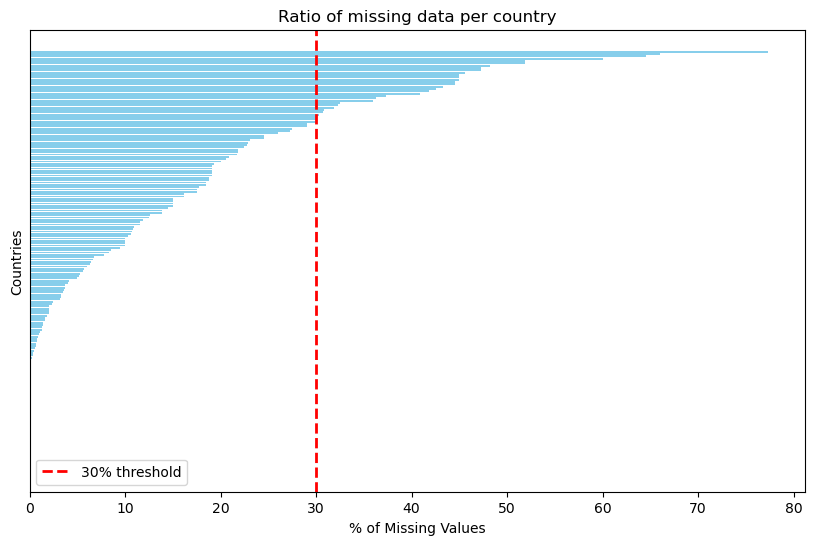

In [21]:
# Get NaN values by country
nan_by_country = data.groupby('iso3')[cols_to_check].apply(lambda x: x.isna().mean().mean() * 100)
nan_by_country = nan_by_country.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,6))
plt.barh(range(len(nan_by_country)), nan_by_country.values, color='skyblue')  # use range for no labels
plt.axvline(x=30, color='red', linestyle='--', linewidth=2, label='30% threshold')  # red line at 30%
plt.xlabel('% of Missing Values')
plt.ylabel("Countries")
plt.title('Ratio of missing data per country')
plt.yticks([])  # remove y-axis labels
plt.legend()
plt.gca().invert_yaxis()  # largest on top
plt.show()


From the graph, we can see that a lot of the countries have a majority of their data missing. We have decided to exclude countries that have more than 70 per cent data missing, which is indicated by the red line in the graph.

In [22]:
def nan_mean(x):
    return x.isna().mean().mean() * 100
        
before_excl = len(data["iso3"].unique())
# Compute missing-data percentage per country
country_nan_percent = data.groupby('iso3')[cols_to_check].apply(nan_mean)

# Keep only countries with <= 30% missing data
valid_countries = country_nan_percent[country_nan_percent <= 30].index

# Filter the main DataFrame
data = data[data['iso3'].isin(valid_countries)]
after_excl = len(data["iso3"].unique())

print(f"{before_excl - after_excl} countries removed from the data.")

28 countries removed from the data.


Now, we want to inspect the trends of missing data between different factors in our dataset.

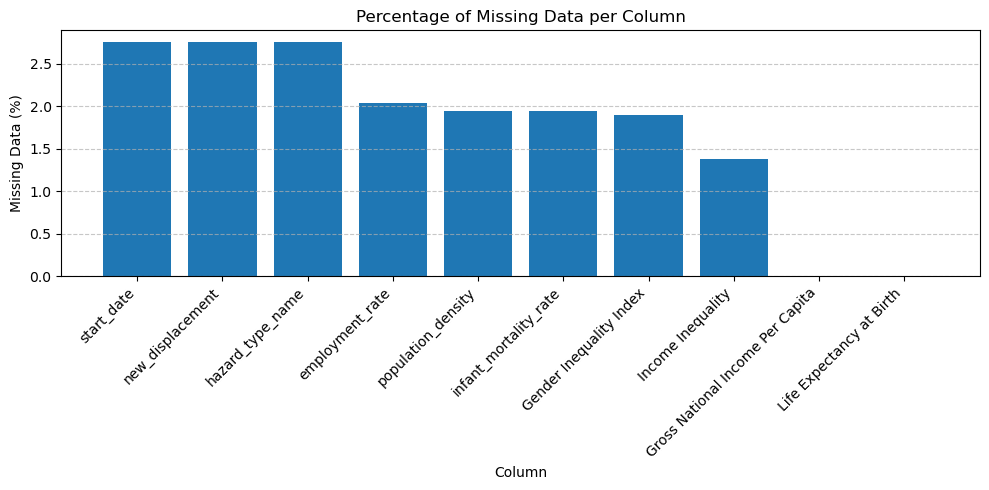


Missing data percentage per column (sorted):
start_date                          2.753560
new_displacement                    2.753560
hazard_type_name                    2.753560
employment_rate                     2.032240
population_density                  1.944427
infant_mortality_rate               1.944427
Gender Inequality Index             1.894248
Income Inequality                   1.379916
Gross National Income Per Capita    0.000000
Life Expectancy at Birth            0.000000
dtype: float64


In [23]:
# Get NaN values per column
nan_per_column = data[cols_to_check].isna().mean() * 100
nan_per_column_sorted = nan_per_column.sort_values(ascending=False)

# Plot NaN values
plt.figure(figsize=(10,5))
plt.bar(nan_per_column_sorted.index, nan_per_column_sorted.values)
plt.title(f'Percentage of Missing Data per Column')
plt.xlabel('Column')
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nMissing data percentage per column (sorted):")
print(nan_per_column_sorted)

There is no feature with  significant amount of missing data wherefore we can keep all chosen indicators.

## 2.3 Uniformize data
Next, we look at the minimum and maximum values each column can obtain. 

In [28]:
numeric_cols = ["new_displacement", "employment_rate", "population_density", "infant_mortality_rate", "Gender Inequality Index", "Income Inequality", "Gross National Income Per Capita", "Life Expectancy at Birth"]
# Print min and max values of each column
min_max = data[numeric_cols].agg(["min", "max"]).transpose().reset_index()
min_max.columns = ["Column", "min", "max"]
print(min_max)

# Multiply GII by a 100
data["Gender Inequality Index"] = data["Gender Inequality Index"] * 100

                             Column         min           max
0                  new_displacement    1.000000  7.245490e+06
1                   employment_rate   20.854000  8.540900e+01
2                population_density    1.861618  1.765081e+03
3             infant_mortality_rate    1.800000  1.891000e+02
4           Gender Inequality Index    0.003000  8.400000e-01
5                 Income Inequality    3.587569  6.339851e+01
6  Gross National Income Per Capita  688.347277  1.134540e+05
7          Life Expectancy at Birth   18.818000  8.471200e+01


What do we do with values?
new displacement --> number of people
emplyment rate --> 0-100% is fine
population density --> not sure
infant mortality --> not sure 
gii --> 0-1 so make 0-100 then fine
income --> 0-100 is fine
gni --> not sure
life expectancy --> not sure 

## 2.4 Missing values
We examine the number of missing values in the dataset to determine an appropriate strategy for handling them. Addressing missing data is essential because it can bias results, reduce the reliability of our analyses, and hinder modeling performance. Many machine learning algorithms cannot process missing values directly and require complete input data. Therefore, understanding the extent and pattern of missingness ensures that subsequent analyses and models are both accurate and valid.

In [29]:
# Inspect the remaining nan values
data.isna().sum()

iso3                                  0
year                                  0
start_date                          439
new_displacement                    439
hazard_type_name                    439
Gender Inequality Index             302
Gross National Income Per Capita      0
Income Inequality                   220
Life Expectancy at Birth              0
population_density                  310
infant_mortality_rate               310
employment_rate                     324
dtype: int64

439 so no disaster reported for that year in that country which is a good observation and should not be dropped 
others can be imputed 


In [31]:
imputer = SimpleImputer(strategy="median")

values_to_impute = ml_vars = ["employment_rate", "population_density", "infant_mortality_rate", "Gender Inequality Index", "Income Inequality"]

data[ml_vars] = imputer.fit_transform(data[ml_vars])
